In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import glob
import platform
import pathlib  
import os.path
import datetime
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import netCDF4 as nc
import tempfile

In [2]:
# Import the correct files from computer

cwd = pathlib.Path().resolve()
src = cwd.parent
data = src.parent.parent.parent
OS_type = platform.system()

if OS_type == 'Darwin':
    username = 'Mats '
    data_path = os.path.join(data, 'data_tana', 'Sattelite')
else:
    username = 'Mootje'
    data_path = os.path.join(data, 'OneDrive - Delft University of Technology', 'TU Delft', 'Master ENVM', 'MDP', 'Model', 'Data', 'Satellite')
    data_path_tahmo = os.path.join(data, 'OneDrive - Delft University of Technology', 'TU Delft', 'Master ENVM', 'MDP', 'Model', 'Data', 'TAHMO','location_data_tahmoTA00023.csv')
    shape_path = os.path.join(data, 'OneDrive - Delft University of Technology', 'TU Delft', 'Master ENVM', 'MDP', 'Model', 'Data', 'Shapefiles')

print(f"Welcome {username}, have a wondeful day on your {OS_type} machine. Your data should be located in {data_path}")

Welcome Mootje, have a wondeful day on your Windows machine. Your data should be located in C:\Users\Moniek van Zon\OneDrive - Delft University of Technology\TU Delft\Master ENVM\MDP\Model\Data\Satellite


In [3]:
# Open all sattelite data 

data_files = glob.glob(os.path.join(data_path, '*.nc'))

datasets = {}

for file_path in data_files:
    # Get just the file name
    file_name = os.path.basename(file_path)  
    
    # Substract the name from the file, for clarification of the different datasets in the dictionary
    file_identifier = file_name.split('_')[0]  

    # Open the dataset
    dataset = xr.open_dataset(file_path)

    # Add the file identifier as a new coordinate
    dataset = dataset.assign_coords(file_identifier=file_identifier)
    
    # Add the dataset to the dictionary with the file identifier as the key
    datasets[file_identifier] = dataset

# Select the Chirps file from all the files in data_files
chirps_file = data_files[0]

In [4]:
# Check the CHIRPS dataset
chirps = datasets['chirps']
chirps

<xarray.Dataset> Size: 463MB
Dimensions:          (latitude: 210, longitude: 302, time: 1826)
Coordinates:
  * latitude         (latitude) float32 840B -5.025 -4.975 ... 5.375 5.425
  * longitude        (longitude) float32 1kB 28.47 28.52 28.57 ... 43.47 43.52
  * time             (time) datetime64[ns] 15kB 2018-01-01 ... 2022-12-31
    file_identifier  <U6 24B 'chirps'
Data variables:
    precip           (time, latitude, longitude) float32 463MB ...
Attributes: (12/15)
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2019-01-30
    creator_name:      Pete Peterson
    ...                ...
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given day....
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ

In [5]:
# Check time values

time_values = chirps.variables['time'][:]
time_values


<xarray.IndexVariable 'time' (time: 1826)> Size: 15kB
array(['2018-01-01T00:00:00.000000000', '2018-01-02T00:00:00.000000000',
       '2018-01-03T00:00:00.000000000', ..., '2022-12-29T00:00:00.000000000',
       '2022-12-30T00:00:00.000000000', '2022-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Attributes:
    standard_name:  time
    axis:           T

In [6]:
# loading station data from TAHMO

df_loc = pd.read_csv(data_path_tahmo, index_col = 0, sep =',', parse_dates = True)
long = df_loc['longitude'].iloc[0]
lat = df_loc['lattitude'].iloc[0]

chirps_file = chirps
station_file = df_loc

[datetime.datetime(2018, 1, 1, 0, 0), datetime.datetime(2018, 1, 2, 0, 0), datetime.datetime(2018, 1, 3, 0, 0), datetime.datetime(2018, 1, 4, 0, 0), datetime.datetime(2018, 1, 5, 0, 0), datetime.datetime(2018, 1, 6, 0, 0), datetime.datetime(2018, 1, 7, 0, 0), datetime.datetime(2018, 1, 8, 0, 0), datetime.datetime(2018, 1, 9, 0, 0), datetime.datetime(2018, 1, 10, 0, 0), datetime.datetime(2018, 1, 11, 0, 0), datetime.datetime(2018, 1, 12, 0, 0), datetime.datetime(2018, 1, 13, 0, 0), datetime.datetime(2018, 1, 14, 0, 0), datetime.datetime(2018, 1, 15, 0, 0), datetime.datetime(2018, 1, 16, 0, 0), datetime.datetime(2018, 1, 17, 0, 0), datetime.datetime(2018, 1, 18, 0, 0), datetime.datetime(2018, 1, 19, 0, 0), datetime.datetime(2018, 1, 20, 0, 0), datetime.datetime(2018, 1, 21, 0, 0), datetime.datetime(2018, 1, 22, 0, 0), datetime.datetime(2018, 1, 23, 0, 0), datetime.datetime(2018, 1, 24, 0, 0), datetime.datetime(2018, 1, 25, 0, 0), datetime.datetime(2018, 1, 26, 0, 0), datetime.datetime(20

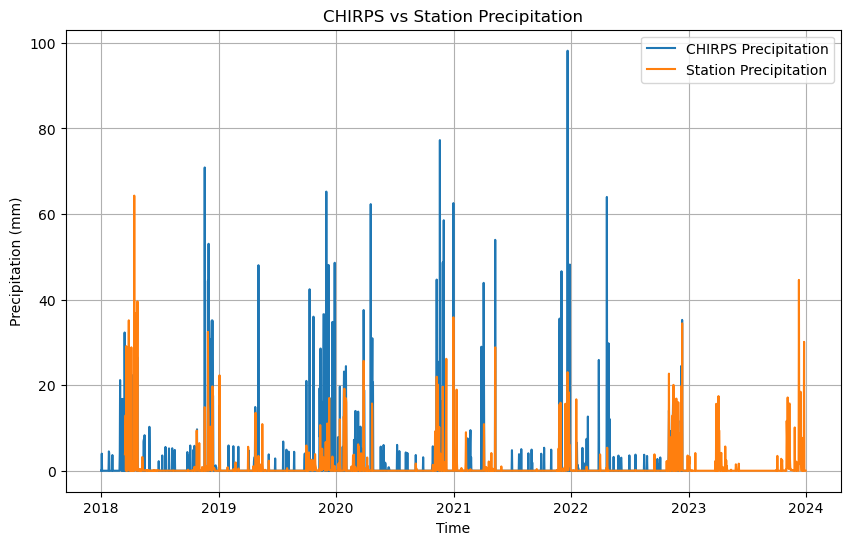

Correlation Coefficient: 0.43710460374020116
Root Mean Square Error (RMSE): 7.0216401651164775


In [7]:
# The difference between satellite (CHIRPS) and station data (TAHMO), for a specific location

def extract_chirps_data(chirps_file, lat, lon):
    with nc.Dataset(chirps_file, 'r') as dataset:
        # Subsstract the correct values from the dataset
        lat_values = dataset.variables['latitude'][:]
        lon_values = dataset.variables['longitude'][:]
        time_values = dataset.variables['time'][:]
        precipitation_values = dataset.variables['precip'][:]

        # Defining the range of latitude and longitude
        lat_index = np.abs(lat_values - lat).argmin()
        lon_index = np.abs(lon_values - lon).argmin()

        chirps_precip = precipitation_values[:, lat_index, lon_index]

        # Convert numerical time steps to datetime objects
        units = dataset.variables['time'].units
        start_date = datetime.datetime.strptime(units, "days since %Y-%m-%d")
        chirps_time = [start_date + datetime.timedelta(days=int(time_step)) for time_step in time_values]

    return chirps_time, chirps_precip

# Function to extract station data for a specific location
def extract_station_data(station_file):
    station_data = pd.read_csv(station_file)
    return station_data

# Function to calculate correlation coefficient and RMSE
def calculate_metrics(chirps_time, chirps_precip, station_time, station_precip):
    
    # Convert datetime objects to timestamps
    chirps_timestamps = [time.timestamp() for time in chirps_time]
    station_timestamps = [time.timestamp() for time in station_time]
    
    # Interpolate station data to match CHIRPS time points
    interpolated_station_precip = np.interp(chirps_timestamps, station_timestamps, station_precip)
    
    # Calculate correlation coefficient and RMSE
    correlation = np.corrcoef(chirps_precip, interpolated_station_precip)[0, 1]
    rmse = np.sqrt(np.mean((chirps_precip - interpolated_station_precip)**2))
    
    return correlation, rmse


# Main function
def main():
    # Specify the location (latitude and longitude) for verification
    target_lat = lat
    target_lon = long

    # Save chirps_file to a temporary NetCDF file
    with tempfile.NamedTemporaryFile(suffix='.nc', delete=False) as temp_chirps_file:
        chirps.to_netcdf(temp_chirps_file.name)
        temp_chirps_file_path = temp_chirps_file.name

    # Extract data for the specified location
    chirps_time, chirps_precip = extract_chirps_data(temp_chirps_file_path, target_lat, target_lon)
    print(chirps_time)

    # Station_data
    station_data = extract_station_data(data_path_tahmo)
    station_time = pd.to_datetime(station_data['Timestamp'])
    station_precip = station_data['pr']

    # Calculate correlation coefficient and RMSE
    correlation, rmse = calculate_metrics(chirps_time, chirps_precip, station_time, station_precip)

    # Plot CHIRPS and station precipitation
    plt.figure(figsize=(10, 6))
    plt.plot(chirps_time, chirps_precip, label='CHIRPS Precipitation')
    plt.plot(station_time, station_precip, label='Station Precipitation')
    plt.xlabel('Time')
    plt.ylabel('Precipitation (mm)')
    plt.title('CHIRPS vs Station Precipitation')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print verification metrics
    print(f'Correlation Coefficient: {correlation}')
    print(f'Root Mean Square Error (RMSE): {rmse}')

if __name__ == "__main__":
    main()


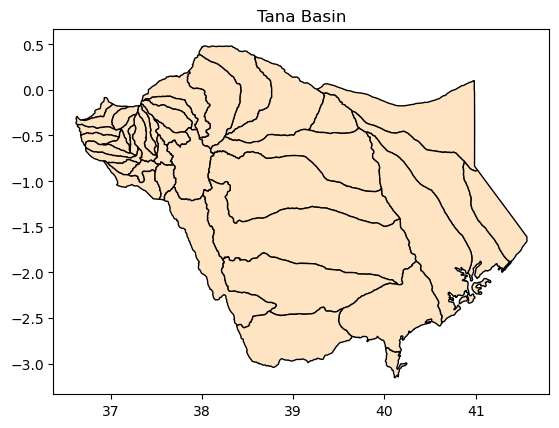

In [8]:
# Read the shapefile of the specified location
shape_file = os.path.join(shape_path, '*.gpkg')
shape_files = glob.glob(shape_file)
gdfs = []

for file in shape_files:
    gdf = gpd.read_file(file)
    gdfs.append(gdf)

merged_gdfs = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))

# Plot the shapefile
ax = merged_gdfs.plot(color='bisque', edgecolor='black')
# Add a title to the plot
plt.title('Tana Basin')

plt.show()

In [9]:
chirps_file['time']
start_date = '2023-10-01'
end_date = '2023-12-31'

chirps_OND_23 = chirps.sel(time = slice(start_date, end_date))


In [10]:
def clip_netCDF_to_geopackage(netCDF_file, geopackage_file):
    # Open the GeoPackage file
    geopackage_gdf = gpd.read_file(geopackage_file)

    # Open the NetCDF file
    with rasterio.open(netCDF_file) as src:
        # Read the NetCDF data
        data = src.read(1)

        # Clip the NetCDF data to the GeoPackage boundaries
        clipped_data, _ = mask(src, geopackage_gdf.geometry, crop=True, nodata=np.nan)

        # Get metadata for the clipped data
        meta = src.meta.copy()

    return clipped_data, meta

# Example usage:

netCDF_file = data_files[0]  # Assuming data_files contains the list of NetCDF file paths
for geopackage_file in shape_files:  # Assuming shape_files is a list of GeoPackage file paths
    clipped_data, meta = clip_netCDF_to_geopackage(netCDF_file, geopackage_file)

# clipped_data, meta = clip_netCDF_to_geopackage(chirps_file, shape_files)
clipped_data

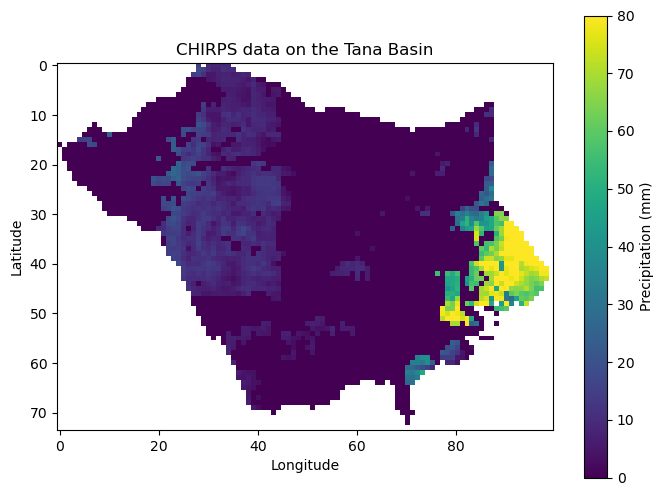

In [ ]:
# Select one of the frames from clipped data
frame_index = 150
frame_data = clipped_data[frame_index]

# Define the range for the color scale
vmin = 0  # Minimum value
vmax = 80  # Maximum value

# Plot the figure for the chosen frame
plt.figure(figsize=(8, 6))
plt.imshow(frame_data, vmin=vmin, vmax=vmax)
plt.colorbar(label='Precipitation (mm)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('CHIRPS data on the Tana Basin')
# plt.grid(True)

plt.show()

In [ ]:
clipped_values = clipped_data[~np.isnan(clipped_data)]
min_value = np.nanmin(clipped_values)
max_value = np.nanmax(clipped_values)
print(min_value)

# Determine the 99 percentile for the colourbar
percentile_90 = np.nanpercentile(clipped_values, 99)
percentile_90

0.0


41.87806617736814

In [ ]:
# Define a function to update the plot for each frame
def update(frame):
    plt.clf()  # Clear the current figure to update with the next frame
    plt.imshow(clipped_data[frame], vmin=min_value, vmax=percentile_90)
    plt.colorbar(label='Precipitation (mm)', ticks=[overall_min, percentile_90])  # Add colorbar with fixed scale
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Clipped NetCDF Data (Time Step {frame})')
    # plt.grid(True)

# Uncommend the part below to get the animation
# # Create a figure and axis for the animation
# fig, ax = plt.subplots(figsize=(8, 6))

# # Create the animation
# animation = FuncAnimation(fig, update, frames=len(clipped_data), interval=100)

# # Save the animation as a GIF
# animation.save('clipped_data_animation.gif', writer='pillow')  # Use 'imagemagick' if 'pillow' does not work

# # Show the animation (optional)
# plt.show()